# Common
## Imports

In [1]:
from platform import python_version

print(python_version())

3.7.6


In [2]:
import gym

import hiive.mdptoolbox as mdptoolbox
from hiive.mdptoolbox.mdp import ValueIteration, PolicyIteration, QLearning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from IPython.display import clear_output, display

# suppress pandas warning
pd.options.mode.chained_assignment = None

%matplotlib inline

# Helper Functions

In [3]:
colors = {
    b'S': 'b',
    b'F': 'w',
    b'H': 'k',
    b'G': 'g'
}

directions = {
            0: '←',
            1: '↓',
            2: '→',
            3: '↑'
}

def plot_lake(env, policy=None, title='Frozen Lake'):
    squares = env.nrow
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, xlim=(-.01, squares+0.01), ylim=(-.01, squares+0.01))
    plt.title(title, fontsize=16, weight='bold', y=1.01)
    for i in range(squares):
        for j in range(squares):
            y = squares - i - 1
            x = j
            p = plt.Rectangle([x, y], 1, 1, linewidth=1, edgecolor='k')
            p.set_facecolor(colors[env.desc[i,j]])
            ax.add_patch(p)
            
            if policy is not None:
                text = ax.text(x+0.5, y+0.5, directions[policy[i, j]],
                               horizontalalignment='center', size=25, verticalalignment='center',
                               color='k')
            
    plt.axis('off')
    plt.savefig('./figures/frozen/' + title + '.png')
    
#plot_lake(env, policy)

In [4]:
# code based on:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def get_score(env, policy, episodes=1000):
    misses = 0
    steps_list = []
    for episode in range(episodes):
        observation = env.reset()
        steps=0
        while True:
            action = policy[observation]
            observation, reward, done, _ = env.step(action)
            steps+=1
            if done and reward == 1:
                # print('You have got the Frisbee after {} steps'.format(steps))
                steps_list.append(steps)
                break
            elif done and reward == 0:
                # print("You fell in a hole!")
                misses += 1
                break
    print('----------------------------------------------')
    ave_steps = np.mean(steps_list)
    pct_fail  = (misses/episodes)* 100
    print('You took an average of {:.0f} steps to get the frisbee'.format(ave_steps))
    print('And you fell in the hole {:.2f} % of the times'.format(pct_fail))
    print('----------------------------------------------')
  
    return ave_steps, pct_fail


In [5]:
# code based on:
# https://medium.com/analytics-vidhya/solving-the-frozenlake-environment-from-openai-gym-using-value-iteration-5a078dffe438
def get_policy(env,stateValue, lmbda=0.9):
    policy = [0 for i in range(env.nS)]
    for state in range(env.nS):
        action_values = []
        for action in range(env.nA):
            action_value = 0
            for i in range(len(env.P[state][action])):
                prob, next_state, r, _ = env.P[state][action][i]
                action_value += prob * (r + lmbda * stateValue[next_state])
            action_values.append(action_value)
        best_action = np.argmax(np.asarray(action_values))
        policy[state] = best_action
    return policy 

# Setup Problem

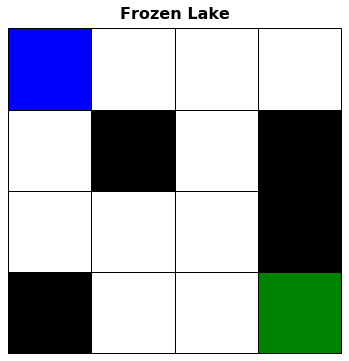

In [6]:
# Setup 4x4
env = gym.make('FrozenLake-v0').unwrapped

# Create transition and reward matrices from OpenAI P matrix
rows = env.nrow
cols = env.ncol
T = np.zeros((4, rows*cols, rows*cols))
R = np.zeros((4, rows*cols, rows*cols))

old_state = np.inf

for square in env.P:
    for action in env.P[square]:
        for i in range(len(env.P[square][action])):
            new_state = env.P[square][action][i][1]
            if new_state == old_state:
                T[action][square][env.P[square][action][i][1]] = T[action][square][old_state] + env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = R[action][square][old_state] + env.P[square][action][i][2]
            else:
                T[action][square][env.P[square][action][i][1]] = env.P[square][action][i][0]
                R[action][square][env.P[square][action][i][1]] = env.P[square][action][i][2]
            old_state = env.P[square][action][i][1]
            
#print(T)
#print(R)
plot_lake(env)

# Value Iteration

In [9]:
def valueIteration(t, r, gammas, epsilons, plot=False, max_iterations=100000):
    # create data structure to save off
    columns = ['gamma', 'epsilon', 'time', 'iterations', 'reward', 'mean_rewards', 'max_rewards', 'error', 'policy', 'average_steps', 'success_pct']
    data = pd.DataFrame(0.0, index=np.arange(len(gammas)*len(epsilons)), columns=columns)
    
    print('Gamma,\tEps,\tTime,\tIter,\tReward')
    print(80*'_')
    
    testNum = 0
    for g in gammas:
        for e in epsilons:
            test = ValueIteration(t, r, gamma=g, max_iter=10000, epsilon=e)
            
            runs  = test.run()
            time  = runs[-1]['Time']
            iters = runs[-1]['Iteration']
            maxR  = runs[-1]['Max V']
            
            max_rewards, mean_rewards, errors = [], [], []
            for run in runs:
                max_rewards.append(run['Max V'])
                mean_rewards.append(run['Mean V'])
                errors.append(run['Error'])
            
            policy = np.array(test.policy)
            policy = policy.reshape(4,4)
            
            data['gamma'][testNum]        = g
            data['epsilon'][testNum]      = e
            data['time'][testNum]         = time
            data['iterations'][testNum]   = iters
            data['reward'][testNum]       = maxR
            data['mean_rewards'][testNum] = {tuple(mean_rewards)}
            data['max_rewards'][testNum]  = {tuple(max_rewards)}
            data['error'][testNum]        = {tuple(errors)}
            data['policy'][testNum]       = {test.policy}
            
            print('%.2f,\t%.0E,\t%.2f,\t%d,\t%f' % (g, e, time, iters, maxR))
            
            if plot:
                title = 'FrozenLake_' + str(rows) + 'x' + str(cols) + '_g' + str(g) + '_e' + str(e)
                plot_lake(env, policy, title)
            
            testNum = testNum + 1
            
    return data

In [10]:
gammas   = [0.3, 0.6, 0.9]
epsilons = [1e-4, 1e-8, 1e-12]
vi_data  = valueIteration(T, R, gammas, epsilons, plot=False)

vi_data.head(len(gammas)*len(epsilons))

Gamma,	Eps,	Time,	Iter,	Reward
________________________________________________________________________________
0.30,	1E-04,	0.00,	6,	0.375077
0.30,	1E-08,	0.00,	13,	0.375103
0.30,	1E-12,	0.00,	20,	0.375103
0.60,	1E-04,	0.00,	13,	0.447623
0.60,	1E-08,	0.00,	29,	0.447649
0.60,	1E-12,	0.00,	46,	0.447649
0.90,	1E-04,	0.00,	60,	0.639007
0.90,	1E-08,	0.01,	128,	0.639020
0.90,	1E-12,	0.01,	195,	0.639020


,gamma,epsilon,time,iterations,reward,mean_rewards,max_rewards,error,policy,average_steps,success_pct
0,0.3,1.000000e-04,0.000607,6.0,0.375077,"{(0.020833333333333332, 0.02708333333333333, 0...","{(0.3333333333333333, 0.36666666666666664, 0.3...","{(0.3333333333333333, 0.03333333333333333, 0.0...","{(1, 2, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...",0.0,0.0
1,0.3,1.000000e-08,0.001071,13.0,0.375103,"{(0.020833333333333332, 0.02708333333333333, 0...","{(0.3333333333333333, 0.36666666666666664, 0.3...","{(0.3333333333333333, 0.03333333333333333, 0.0...","{(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...",0.0,0.0
2,0.3,1.000000e-12,0.002968,20.0,0.375103,"{(0.020833333333333332, 0.02708333333333333, 0...","{(0.3333333333333333, 0.36666666666666664, 0.3...","{(0.3333333333333333, 0.03333333333333333, 0.0...","{(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...",0.0,0.0
3,0.6,1.000000e-04,0.001431,13.0,0.447623,"{(0.020833333333333332, 0.03333333333333333, 0...","{(0.3333333333333333, 0.39999999999999997, 0.4...","{(0.3333333333333333, 0.06666666666666667, 0.0...","{(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...",0.0,0.0
4,0.6,1.000000e-08,0.003019,29.0,0.447649,"{(0.020833333333333332, 0.03333333333333333, 0...","{(0.3333333333333333, 0.39999999999999997, 0.4...","{(0.3333333333333333, 0.06666666666666667, 0.0...","{(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...",0.0,0.0
5,0.6,1.000000e-12,0.003978,46.0,0.447649,"{(0.020833333333333332, 0.03333333333333333, 0...","{(0.3333333333333333, 0.39999999999999997, 0.4...","{(0.3333333333333333, 0.06666666666666667, 0.0...","{(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...",0.0,0.0
6,0.9,1.000000e-04,0.003905,60.0,0.639007,"{(0.020833333333333332, 0.03958333333333333, 0...","{(0.3333333333333333, 0.4333333333333333, 0.49...","{(0.3333333333333333, 0.09999999999999999, 0.0...","{(0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...",0.0,0.0
7,0.9,1.000000e-08,0.008844,128.0,0.639020,"{(0.020833333333333332, 0.03958333333333333, 0...","{(0.3333333333333333, 0.4333333333333333, 0.49...","{(0.3333333333333333, 0.09999999999999999, 0.0...","{(0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...",0.0,0.0
8,0.9,1.000000e-12,0.012506,195.0,0.639020,"{(0.020833333333333332, 0.03958333333333333, 0...","{(0.3333333333333333, 0.4333333333333333, 0.49...","{(0.3333333333333333, 0.09999999999999999, 0.0...","{(0, 3, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...",0.0,0.0


In [11]:
# See differences in policy
policies = vi_data['policy']

for i,p in enumerate(policies):
    pol = list(p)[0]
    steps, failures = get_score(env, pol)
    vi_data['average_steps'][i] = steps
    vi_data['success_pct'][i] = 100-failures
    
vi_data.head()

----------------------------------------------
You took an average of 20 steps to get the frisbee
And you fell in the hole 78.00 % of the times
----------------------------------------------
----------------------------------------------
You took an average of 31 steps to get the frisbee
And you fell in the hole 54.10 % of the times
----------------------------------------------
----------------------------------------------
You took an average of 28 steps to get the frisbee
And you fell in the hole 59.00 % of the times
----------------------------------------------
----------------------------------------------
You took an average of 30 steps to get the frisbee
And you fell in the hole 54.30 % of the times
----------------------------------------------
----------------------------------------------
You took an average of 30 steps to get the frisbee
And you fell in the hole 54.00 % of the times
----------------------------------------------
---------------------------------------------

,gamma,epsilon,time,iterations,reward,mean_rewards,max_rewards,error,policy,average_steps,success_pct
0,0.3,1.000000e-04,0.000607,6.0,0.375077,"{(0.020833333333333332, 0.02708333333333333, 0...","{(0.3333333333333333, 0.36666666666666664, 0.3...","{(0.3333333333333333, 0.03333333333333333, 0.0...","{(1, 2, 0, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...",20.231818,22.0
1,0.3,1.000000e-08,0.001071,13.0,0.375103,"{(0.020833333333333332, 0.02708333333333333, 0...","{(0.3333333333333333, 0.36666666666666664, 0.3...","{(0.3333333333333333, 0.03333333333333333, 0.0...","{(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...",30.501089,45.9
2,0.3,1.000000e-12,0.002968,20.0,0.375103,"{(0.020833333333333332, 0.02708333333333333, 0...","{(0.3333333333333333, 0.36666666666666664, 0.3...","{(0.3333333333333333, 0.03333333333333333, 0.0...","{(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...",27.675610,41.0
3,0.6,1.000000e-04,0.001431,13.0,0.447623,"{(0.020833333333333332, 0.03333333333333333, 0...","{(0.3333333333333333, 0.39999999999999997, 0.4...","{(0.3333333333333333, 0.06666666666666667, 0.0...","{(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...",30.052516,45.7
4,0.6,1.000000e-08,0.003019,29.0,0.447649,"{(0.020833333333333332, 0.03333333333333333, 0...","{(0.3333333333333333, 0.39999999999999997, 0.4...","{(0.3333333333333333, 0.06666666666666667, 0.0...","{(1, 3, 2, 3, 0, 0, 0, 0, 3, 1, 0, 0, 0, 2, 1,...",29.902174,46.0


Text(0, 0.5, 'Average Steps')

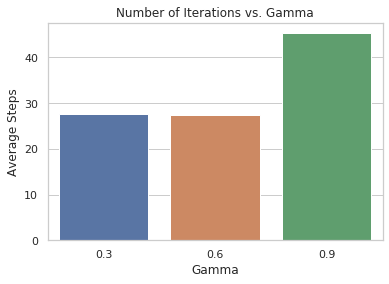

In [17]:
# Compare number of iterations with lowest epsilon
x = gammas
y = vi_data.loc[vi_data['epsilon'] == min(epsilons)]['average_steps']


sns.set(style="whitegrid")
fig=plt.figure()

ax = sns.barplot(x, y)
ax.set_title('Number of Iterations vs. Gamma')
ax.set_xlabel('Gamma')
ax.set_ylabel('Average Steps')


In [15]:
# Compare success of runs
x = gammas
y = vi_data.loc[vi_data['epsilon'] == min(epsilons)]['success_pct']

fig=plt.figure()

2    41.0
5    44.6
8    77.4
Name: success_pct, dtype: float64

# Policy Iteration

In [ ]:
def policy_iteration(env, max_iterations=100000, lmbda=0.9):
    pass

# Run VI

In [ ]:
Us = value_iteration(env)

In [ ]:
policy = get_policy(env, Us)

In [ ]:
get_score(env, policy)

# Run PI

# Q-Learning